In [4]:
import pandas as pd
import numpy as np
import scipy.stats as st


import matplotlib
from matplotlib import pyplot as plt
# matplotlib settings
from IPython.display import set_matplotlib_formats
matplotlib.style.use('classic')
set_matplotlib_formats('pdf', 'svg')
from matplotlib import rcParams
# rcParams['font.family'] x/= 'serif'
import pickle as pkl

from finite import curves_one_stage, curves_two_stage
from finite import greedy, dp, beta, get_data
from tqdm import tqdm_notebook

# Read data

In [7]:
data = pd.read_csv("./data/jee/jee2009.csv") # if missing, download here https://github.com/AnayMehrotra/Ranking-with-Implicit-Bias
data = data.dropna(subset=['mark', 'GENDER'])

In [8]:
data.head()

REGST_NO             NAME category sub_category GENDER PIN_RES  \
0   2045263        VIBHU PAL       GE           NN      M  208011   
1   2023172  NITESH BHARDWAJ       GE           NN      M  110046   
2   2040146          MANJEET       GE           NN      M  110085   
3   2032358    SHIKHAR DATTA       GE           NN      M  110075   
4   2078152            RAJAT       GE           NN      M  121001   

            PARENT_NAM  math  phys  chem  mark  
0      SAROJ KUMAR PAL    30    33    26    89  
1  OM PRAKASH BHARDWAJ    38    26    33    97  
2       DEVENDER SINGH    29    10    30    69  
3    SUNIL KUMAR DATTA     6    -8    12    10  
4      RAJESHWAR SINGH    11    -4    -9    -2

In [9]:
data.shape

(384970, 11)

In [10]:
q = np.copy(data.mark.to_numpy()).astype('float')
g = np.copy(data.GENDER.to_numpy())
g[g == 'M'] = 0
g[g == 'F'] = 1

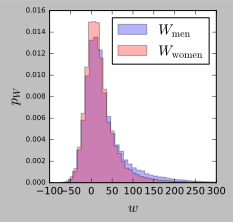

In [11]:
plt.figure(figsize=(3,3))
x = np.arange(-200, 300, 0.1)
_=plt.hist(q[g==0], bins=50, color='b', alpha=0.3, density=True, label='$W_\mathrm{men}$',histtype='stepfilled')
_=plt.hist(q[g==1], bins=50, color='r', alpha=0.3, density=True, label='$W_\mathrm{women}$', histtype='stepfilled')

mu = np.mean(q[(q > -60)& (q < 100)])
std = np.std(q[(q > -60)& (q < 100)])
# plt.plot(x, st.norm(mu, std).pdf(x), ls='--', lw=1.5, color='k')

plt.xlim(-100, 300)
plt.legend(loc='upper right')
plt.xlabel("$w$", fontsize=14)
plt.ylabel("$p_{W}$", fontsize=14)
plt.yticks(fontsize=7)
plt.xticks(fontsize=10)

plt.savefig("../fig/jee-q.pdf", bbox_inches='tight')

# Add noise

In [12]:
sm = 10
sf = 40
n = len(g)
nf = g.sum()
nm = n - nf
x = np.zeros(n)
x[g==1] = q[g==1] + st.norm(0, sf).rvs(nf)
x[g==0] = q[g==0] + st.norm(0, sm).rvs(nm)

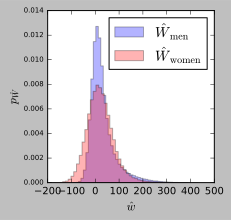

In [13]:
plt.figure(figsize=(3,3))
_=plt.hist(x[g==0], bins=50, color='b', alpha=0.3, density=True, label='$\hat W_\mathrm{men}$', histtype='stepfilled')
_=plt.hist(x[g==1], bins=50, color='r', alpha=0.3, density=True, label='$\hat W_\mathrm{women}$', histtype='stepfilled')
# _=plt.hist(q, bins=50, color='r', alpha=0.3, density=True, label='female')
plt.legend(loc='upper right')
plt.xlabel("$\\hat w$")
# plt.ylabel("$p_{\\hat W}(\\hat w)$", fontsize=14)
plt.ylabel("$p_{\\hat W}$")
plt.yticks(fontsize=7)

plt.xticks(fontsize=10)
plt.savefig("../fig/jee-x.pdf", bbox_inches='tight')

In [14]:
np.std(x[g==0]), np.std(x[g==1])

(52.76077690634529, 56.18021657688576)

In [15]:
np.std(q[g==0]), np.std(q[g==1])

(51.80266380570883, 39.26794876260872)

In [16]:
np.mean(x[g==0]), np.mean(x[g==1])

(30.792997126119076, 21.340545658501267)

In [17]:
np.mean(q[g==0]), np.mean(q[g==1])

(30.792989524015308, 21.235667360346024)

# One-Stage Selection

In [18]:
factors = [1, 4, 7, 10]

In [19]:
a1min = 0.02
a1s = np.arange(a1min, 1.005, 0.005)

res = {'gr': [], 'dp': [], 'beta': []}

sm = 10

for factor in tqdm_notebook(factors):
    x = np.zeros(n)
    x[g==1] = q[g==1] + st.norm(0, sm * factor).rvs(nf)
    x[g==0] = q[g==0] + st.norm(0, sm).rvs(nm)
    data = q, x, g

    res['gr'].append(curves_one_stage(data, a1s, T=1, alg=greedy))
    res['dp'].append(curves_one_stage(data, a1s, T=1, alg=dp))

res['gr'] = np.array(res['gr'])
res['dp'] = np.array(res['dp'])
with open("./data/jee/jee-1-stage-{}.pkl".format(a1min), 'wb') as f:
    pkl.dump(res, f)

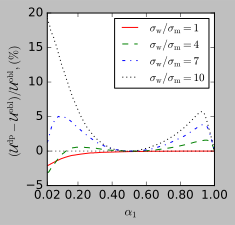

In [20]:
a1min=0.02

with open("./data/jee/jee-1-stage-{}.pkl".format(a1min), 'rb') as f:
    res = pkl.load(f)
             
plt.figure(figsize=(3,3))
color = ['r', 'g', 'b', 'k']
ls = ['-', '--', '-.', ':']

for i, factor in enumerate(factors):
    a1 = res['dp'][i, 0, :]

    plt.plot(a1, (res['dp'][i,1,:] / res['gr'][i,1,:]-1) * 100, '-',\
             label='$\\sigma_\mathrm{w} / \\sigma_\mathrm{m}=$'+'${}$'.format(factor),\
             color=color[i], ls=ls[i])
    plt.axhline(0, ls=':', color='k', alpha=0.2, )

plt.xlabel("$\\alpha_1$")
plt.ylabel("$(\mathcal{U}^\mathrm{dp} - \mathcal{U}^\mathrm{obl}) / \mathcal{U}^\mathrm{obl}, (\%)$\t", rotation=90)
plt.legend(loc='upper right', fontsize=11)
plt.xlim(0.02, 1)
plt.xticks([0.02, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.savefig("../fig/jee-u-one-stage.pdf", bbox_inches='tight')

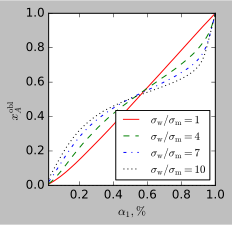

In [21]:
plt.figure(figsize=(3,3))

for i, factor in enumerate(factors):
    a1 = np.array(res['dp'][i, 0, :])
    plt.plot(a1 , np.array(res['gr'][i,2,:]), '-',\
             label='$\\sigma_\mathrm{w} / \\sigma_\mathrm{m}=$'+'${}$'.format(factor),\
             color=color[i], ls=ls[i])
    plt.axhline(0, ls=':', color='k', lw=0.8, alpha=0.2, )

plt.xlabel("$\\alpha_1, \%$")
plt.ylabel("$x_A^\mathrm{obl}$\t", rotation=90)
plt.xlim(0.02,1)
plt.legend(fontsize=11, loc='lower right')
plt.savefig("../fig/jee-x-one-stage.pdf", bbox_inches='tight')

#  Two-Stage Selection

In [23]:
a2 = 0.02
res = {'gr': [], 'dp': [], 'beta': []}

a1s = np.arange(a2, a2 * 2, 0.001)

sm = 10
factors = [1, 4, 7, 10]

for factor in tqdm_notebook(factors):
    x = np.zeros(n)
    x[g==1] = q[g==1] + st.norm(0, sm * factor).rvs(nf)
    x[g==0] = q[g==0] + st.norm(0, sm).rvs(nm)
    data = q, x, g

    res['gr'].append(curves_two_stage(data, a1s, T=1, alg=greedy))
    res['dp'].append(curves_two_stage(data, a1s, T=1, alg=dp))
res['gr'] = np.array(res['gr'])
res['dp'] = np.array(res['dp'])

with open("./data/jee/jee-2-stage-{}.pkl".format(a2), 'wb') as f:
    pkl.dump(res, f)

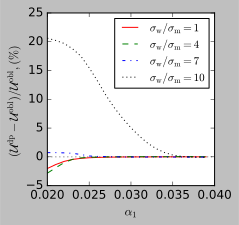

In [25]:
a2=0.02

with open("./data/jee/jee-2-stage-{}.pkl".format(a2), 'rb') as f:
    res = pkl.load(f)
             

plt.figure(figsize=(3,3))
color = ['r', 'g', 'b', 'k']
ls = ['-', '--', '-.', ':']

amax = 0.3
for i, factor in enumerate(factors):
    a1 = np.array(res['dp'][i, 0, :])

    plt.plot(a1[a1 < amax], (np.array(res['dp'][i,1,:])[a1 < amax] / np.array(res['gr'][i,1,:])[a1 < amax]-1)*100, '-',\
             label='$\\sigma_\mathrm{w} / \\sigma_\mathrm{m}=$'+'${}$'.format(factor), color=color[i], ls=ls[i])
    plt.legend(loc='upper right', fontsize=11)
    plt.axhline(0, ls=':', color='k', lw=0.8, alpha=0.2, )
plt.xlabel("$\\alpha_1$")
plt.ylabel("$(\mathcal{U}^\mathrm{dp} - \mathcal{U}^\mathrm{obl}) / \mathcal{U}^\mathrm{obl}, (\%)$\t", rotation=90)
plt.xticks([0.02, 0.025, 0.03,0.035,  0.04])
# plt.yticks(fontsize=14)
plt.savefig("../fig/jee-u-two-stage.pdf", bbox_inches='tight')